In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-11-05 22:37:30--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 3.5.21.132, 52.216.60.72, 16.182.42.8, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|3.5.21.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  2.26MB/s    in 12s     

2023-11-05 22:37:43 (1.12 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
#Google colab tensor flow version is 2.13. So, older version is installed
!pip install tensorflow==2.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 83.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 100.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 39.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.

Inspecting the data of the Jena weather dataset

In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


Parsing the data

In [4]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

Plotting the temperature timeseries

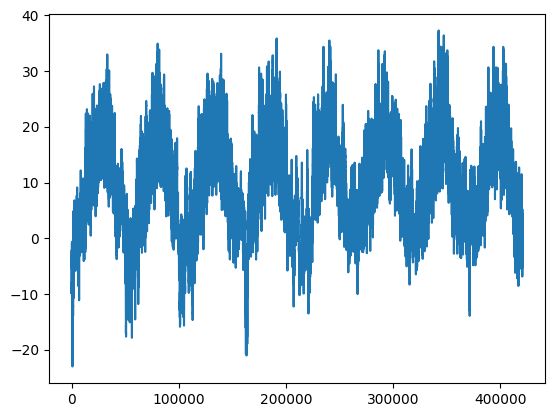

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

Plotting the first 10 days of the temperature timeseries

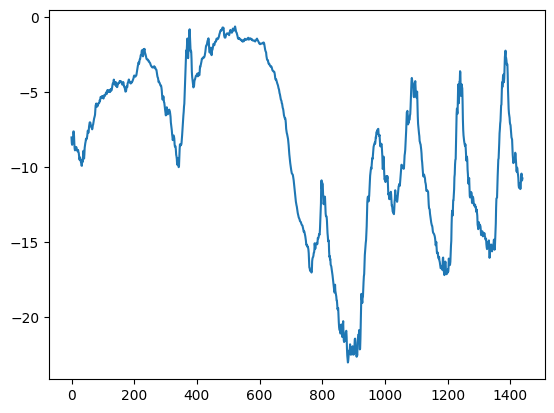

In [6]:
plt.plot(range(1440), temperature[:1440])

Computing the number of samples we'll use for each data split

In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


Normalizing the data

In [8]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [9]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


Instantiating datasets for training, validation, and testing

In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 1000

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

Inspecting the output of one of our datasets

In [11]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (1000, 120, 14)
targets shape: (1000,)


A common-sense, non-machine-learning baseline
Computing the common-sense baseline MAE

In [12]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


A basic machine-learning model - Dense Layer
Training and evaluating a densely connected model

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
210/210 [==============================] - 58s 252ms/step - loss: 16.2491 - mae: 3.0952 - val_loss: 13.4999 - val_mae: 2.9164
Epoch 2/10
210/210 [==============================] - 50s 229ms/step - loss: 10.3601 - mae: 2.5243 - val_loss: 11.5397 - val_mae: 2.6891
Epoch 3/10
210/210 [==============================] - 47s 218ms/step - loss: 9.4826 - mae: 2.4157 - val_loss: 10.5372 - val_mae: 2.5545
Epoch 4/10
210/210 [==============================] - 50s 231ms/step - loss: 8.9859 - mae: 2.3568 - val_loss: 10.2706 - val_mae: 2.5290
Epoch 5/10
210/210 [==============================] - 50s 232ms/step - loss: 8.6701 - mae: 2.3172 - val_loss: 10.5699 - val_mae: 2.5682
Epoch 6/10
210/210 [==============================] - 46s 215ms/step - loss: 8.3432 - mae: 2.2750 - val_loss: 11.5463 - val_mae: 2.6927
Epoch 7/10
210/210 [==============================] - 44s 207ms/step - loss: 8.1647 - mae: 2.2493 - val_loss: 12.2803 - val_mae: 2.7749
Epoch 8/10
210/210 [==========================

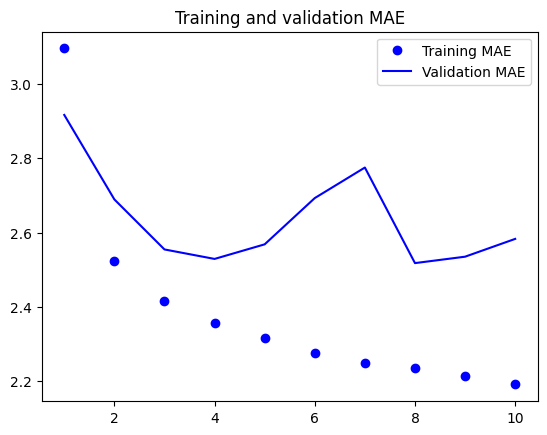

In [14]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Let's try a 1D convolutional model

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
210/210 [==============================] - 51s 207ms/step - loss: 30.5949 - mae: 4.3108 - val_loss: 20.2003 - val_mae: 3.5395
Epoch 2/10
210/210 [==============================] - 42s 196ms/step - loss: 20.3290 - mae: 3.5905 - val_loss: 16.7571 - val_mae: 3.2393
Epoch 3/10
210/210 [==============================] - 43s 196ms/step - loss: 18.1486 - mae: 3.3892 - val_loss: 18.5374 - val_mae: 3.3631
Epoch 4/10
210/210 [==============================] - 43s 203ms/step - loss: 17.0843 - mae: 3.2828 - val_loss: 16.1241 - val_mae: 3.1975
Epoch 5/10
210/210 [==============================] - 51s 237ms/step - loss: 16.2402 - mae: 3.1973 - val_loss: 17.1049 - val_mae: 3.2971
Epoch 6/10
210/210 [==============================] - 44s 201ms/step - loss: 15.7038 - mae: 3.1406 - val_loss: 14.8177 - val_mae: 3.0485
Epoch 7/10
210/210 [==============================] - 52s 242ms/step - loss: 15.2625 - mae: 3.0936 - val_loss: 14.6367 - val_mae: 3.0035
Epoch 8/10
210/210 [=====================

A simple LSTM-based model

In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
210/210 [==============================] - 47s 208ms/step - loss: 81.7681 - mae: 7.1307 - val_loss: 50.7714 - val_mae: 5.4139
Epoch 2/10
210/210 [==============================] - 44s 207ms/step - loss: 38.6768 - mae: 4.6481 - val_loss: 28.0644 - val_mae: 3.9175
Epoch 3/10
210/210 [==============================] - 45s 210ms/step - loss: 22.4440 - mae: 3.5178 - val_loss: 17.0348 - val_mae: 3.0794
Epoch 4/10
210/210 [==============================] - 52s 243ms/step - loss: 14.8492 - mae: 2.9256 - val_loss: 12.1338 - val_mae: 2.6597
Epoch 5/10
210/210 [==============================] - 45s 209ms/step - loss: 11.7535 - mae: 2.6573 - val_loss: 10.4592 - val_mae: 2.5007
Epoch 6/10
210/210 [==============================] - 45s 209ms/step - loss: 10.5867 - mae: 2.5426 - val_loss: 10.0920 - val_mae: 2.4582
Epoch 7/10
210/210 [==============================] - 52s 244ms/step - loss: 10.1288 - mae: 2.4911 - val_loss: 9.8568 - val_mae: 2.4392
Epoch 8/10
210/210 [======================

NumPy implementation of a simple RNN

In [14]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

An RNN layer that can process sequences of any length

In [16]:
from tensorflow import keras
from tensorflow.keras import layers
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimpleRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimpleRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
210/210 [==============================] - 73s 318ms/step - loss: 145.7529 - mae: 10.0117 - val_loss: 146.8775 - val_mae: 10.0344
Epoch 2/10
210/210 [==============================] - 66s 310ms/step - loss: 137.6751 - mae: 9.6222 - val_loss: 144.3736 - val_mae: 9.9124
Epoch 3/10
210/210 [==============================] - 66s 307ms/step - loss: 136.5845 - mae: 9.5681 - val_loss: 144.0917 - val_mae: 9.8994
Epoch 4/10
210/210 [==============================] - 66s 310ms/step - loss: 136.3588 - mae: 9.5541 - val_loss: 143.8977 - val_mae: 9.8877
Epoch 5/10
210/210 [==============================] - 69s 322ms/step - loss: 136.2952 - mae: 9.5507 - val_loss: 143.8303 - val_mae: 9.8778
Epoch 6/10
210/210 [==============================] - 66s 307ms/step - loss: 136.2620 - mae: 9.5483 - val_loss: 143.7696 - val_mae: 9.8732
Epoch 7/10
210/210 [==============================] - 69s 322ms/step - loss: 136.2439 - mae: 9.5468 - val_loss: 143.7720 - val_mae: 9.8739
Epoch 8/10
210/210 [=====

Model with Stacking RNN layers

In [23]:

num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimpleRNN2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimpleRNN2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
210/210 [==============================] - 146s 675ms/step - loss: 138.3694 - mae: 9.6435 - val_loss: 143.5481 - val_mae: 9.8528
Epoch 2/10
210/210 [==============================] - 141s 665ms/step - loss: 136.0678 - mae: 9.5288 - val_loss: 143.4618 - val_mae: 9.8404
Epoch 3/10
210/210 [==============================] - 141s 666ms/step - loss: 136.0157 - mae: 9.5224 - val_loss: 143.4793 - val_mae: 9.8436
Epoch 4/10
210/210 [==============================] - 138s 651ms/step - loss: 135.9828 - mae: 9.5178 - val_loss: 143.4746 - val_mae: 9.8433
Epoch 5/10
210/210 [==============================] - 138s 653ms/step - loss: 135.9686 - mae: 9.5157 - val_loss: 143.4608 - val_mae: 9.8422
Epoch 6/10
210/210 [==============================] - 137s 647ms/step - loss: 135.9446 - mae: 9.5122 - val_loss: 143.4656 - val_mae: 9.8424
Epoch 7/10
210/210 [==============================] - 137s 648ms/step - loss: 135.9223 - mae: 9.5099 - val_loss: 143.4525 - val_mae: 9.8408
Epoch 8/10
210/210 [

**Using recurrent dropout to fight overfitting**

Training and evaluating a dropout-regularized LSTM

In [36]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
210/210 [==============================] - 158s 730ms/step - loss: 51.4263 - mae: 5.3796 - val_loss: 18.2623 - val_mae: 3.1764
Epoch 2/10
210/210 [==============================] - 155s 733ms/step - loss: 19.1554 - mae: 3.3526 - val_loss: 11.0772 - val_mae: 2.5582
Epoch 3/10
210/210 [==============================] - 153s 727ms/step - loss: 15.9235 - mae: 3.0979 - val_loss: 9.8991 - val_mae: 2.4421
Epoch 4/10
210/210 [==============================] - 147s 692ms/step - loss: 15.0017 - mae: 3.0066 - val_loss: 10.3422 - val_mae: 2.5081
Epoch 5/10
210/210 [==============================] - 146s 693ms/step - loss: 14.5450 - mae: 2.9598 - val_loss: 9.5588 - val_mae: 2.3980
Epoch 6/10
210/210 [==============================] - 145s 687ms/step - loss: 14.2084 - mae: 2.9253 - val_loss: 9.6903 - val_mae: 2.4123
Epoch 7/10
210/210 [==============================] - 147s 698ms/step - loss: 13.9665 - mae: 2.8939 - val_loss: 9.5941 - val_mae: 2.4012
Epoch 8/10
210/210 [==================

104/104 [==============================] - 19s 168ms/step - loss: 10.7096 - mae: 2.5948
Test MAE: 2.59


In [23]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)


Simple LSTM model with increased units

In [38]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstmincreased_units.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstmincreased_units.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
210/210 [==============================] - 47s 210ms/step - loss: 47.2314 - mae: 5.1162 - val_loss: 18.7528 - val_mae: 3.2180
Epoch 2/10
210/210 [==============================] - 52s 242ms/step - loss: 14.3665 - mae: 2.8773 - val_loss: 10.7968 - val_mae: 2.5274
Epoch 3/10
210/210 [==============================] - 53s 244ms/step - loss: 10.3164 - mae: 2.5057 - val_loss: 9.9870 - val_mae: 2.4444
Epoch 4/10
210/210 [==============================] - 53s 250ms/step - loss: 9.5718 - mae: 2.4175 - val_loss: 10.1476 - val_mae: 2.4693
Epoch 5/10
210/210 [==============================] - 51s 235ms/step - loss: 9.2417 - mae: 2.3723 - val_loss: 9.8215 - val_mae: 2.4320
Epoch 6/10
210/210 [==============================] - 45s 210ms/step - loss: 8.7894 - mae: 2.3125 - val_loss: 9.9166 - val_mae: 2.4514
Epoch 7/10
210/210 [==============================] - 54s 253ms/step - loss: 8.4791 - mae: 2.2695 - val_loss: 10.5074 - val_mae: 2.5025
Epoch 8/10
210/210 [============================

LSTM Model- Stacked setup with 16 units

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16, return_sequences=True)(x)
x = layers.LSTM(16, return_sequences=True)(x)
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_stacked.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_stacked.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
210/210 [==============================] - 55s 242ms/step - loss: 81.7995 - mae: 7.1463 - val_loss: 49.3227 - val_mae: 5.3483
Epoch 2/10
210/210 [==============================] - 44s 204ms/step - loss: 37.9694 - mae: 4.6175 - val_loss: 27.3070 - val_mae: 3.8762
Epoch 3/10
210/210 [==============================] - 43s 200ms/step - loss: 22.0912 - mae: 3.4992 - val_loss: 16.4546 - val_mae: 3.0350
Epoch 4/10
210/210 [==============================] - 50s 233ms/step - loss: 14.5832 - mae: 2.9024 - val_loss: 11.6596 - val_mae: 2.6139
Epoch 5/10
210/210 [==============================] - 51s 238ms/step - loss: 11.6288 - mae: 2.6397 - val_loss: 10.0960 - val_mae: 2.4658
Epoch 6/10
210/210 [==============================] - 51s 241ms/step - loss: 10.5485 - mae: 2.5282 - val_loss: 9.6415 - val_mae: 2.4143
Epoch 7/10
210/210 [==============================] - 43s 199ms/step - loss: 10.1150 - mae: 2.4792 - val_loss: 9.6895 - val_mae: 2.4189
Epoch 8/10
210/210 [=======================

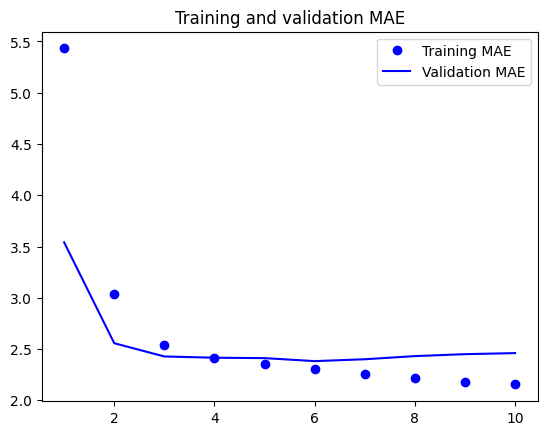

In [28]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

LSTM Model- Stacked setup with 32 units

In [26]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32, return_sequences=True)(x)
x = layers.LSTM(32, return_sequences=True)(x)
x = layers.LSTM(32)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_stacked_adjustedunits1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_stacked_adjustedunits1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
210/210 [==============================] - 55s 244ms/step - loss: 52.3248 - mae: 5.4317 - val_loss: 22.8053 - val_mae: 3.5408
Epoch 2/10
210/210 [==============================] - 43s 200ms/step - loss: 16.3282 - mae: 3.0403 - val_loss: 11.1889 - val_mae: 2.5571
Epoch 3/10
210/210 [==============================] - 44s 205ms/step - loss: 10.6511 - mae: 2.5366 - val_loss: 9.8210 - val_mae: 2.4278
Epoch 4/10
210/210 [==============================] - 45s 207ms/step - loss: 9.6327 - mae: 2.4137 - val_loss: 9.6138 - val_mae: 2.4157
Epoch 5/10
210/210 [==============================] - 45s 209ms/step - loss: 9.1214 - mae: 2.3512 - val_loss: 9.5675 - val_mae: 2.4117
Epoch 6/10
210/210 [==============================] - 51s 238ms/step - loss: 8.7694 - mae: 2.3069 - val_loss: 9.2759 - val_mae: 2.3825
Epoch 7/10
210/210 [==============================] - 45s 210ms/step - loss: 8.4218 - mae: 2.2602 - val_loss: 9.4957 - val_mae: 2.4005
Epoch 8/10
210/210 [==============================

LSTM - Stacked setup with 64 units

In [35]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(64, return_sequences=True)(inputs)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_stacked_adjustedunits2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_stacked_adjustedunits2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
print(f"Validation MAE: {val_mae[-1]:.2f}")

Epoch 1/10
210/210 [==============================] - 48s 204ms/step - loss: 29.4325 - mae: 3.9485 - val_loss: 10.9885 - val_mae: 2.5450
Epoch 2/10
210/210 [==============================] - 52s 242ms/step - loss: 10.1162 - mae: 2.4730 - val_loss: 10.0770 - val_mae: 2.4740
Epoch 3/10
210/210 [==============================] - 44s 208ms/step - loss: 8.7725 - mae: 2.3052 - val_loss: 10.1270 - val_mae: 2.4825
Epoch 4/10
210/210 [==============================] - 44s 207ms/step - loss: 7.9805 - mae: 2.1905 - val_loss: 10.3559 - val_mae: 2.5200
Epoch 5/10
210/210 [==============================] - 44s 204ms/step - loss: 7.3109 - mae: 2.0926 - val_loss: 10.2262 - val_mae: 2.5037
Epoch 6/10
210/210 [==============================] - 51s 234ms/step - loss: 6.7313 - mae: 2.0055 - val_loss: 11.3649 - val_mae: 2.6212
Epoch 7/10
210/210 [==============================] - 51s 240ms/step - loss: 6.1854 - mae: 1.9171 - val_loss: 11.7520 - val_mae: 2.6949
Epoch 8/10
210/210 [==========================

LSTM - Stacked setup with 8 units

In [30]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8, return_sequences=True)(x)
x = layers.LSTM(8, return_sequences=True)(x)
x = layers.LSTM(8)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_stacked_adjustedunits3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_stacked_adjustedunits3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
210/210 [==============================] - 46s 205ms/step - loss: 109.6598 - mae: 8.5329 - val_loss: 78.5839 - val_mae: 6.9875
Epoch 2/10
210/210 [==============================] - 45s 210ms/step - loss: 63.2733 - mae: 6.1567 - val_loss: 52.7076 - val_mae: 5.5476
Epoch 3/10
210/210 [==============================] - 53s 246ms/step - loss: 45.8667 - mae: 5.1221 - val_loss: 38.2446 - val_mae: 4.6275
Epoch 4/10
210/210 [==============================] - 44s 204ms/step - loss: 33.7193 - mae: 4.3224 - val_loss: 27.9254 - val_mae: 3.9057
Epoch 5/10
210/210 [==============================] - 44s 206ms/step - loss: 25.5335 - mae: 3.7465 - val_loss: 20.9202 - val_mae: 3.3848
Epoch 6/10
210/210 [==============================] - 43s 202ms/step - loss: 20.0099 - mae: 3.3302 - val_loss: 16.2027 - val_mae: 2.9992
Epoch 7/10
210/210 [==============================] - 46s 216ms/step - loss: 16.4160 - mae: 3.0394 - val_loss: 13.2348 - val_mae: 2.7563
Epoch 8/10
210/210 [====================

In [31]:
#combining the 1D convolution network with RNN.
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("combined_model.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
210/210 [==============================] - 53s 241ms/step - loss: 91.7918 - mae: 7.6494 - val_loss: 61.6875 - val_mae: 6.0639
Epoch 2/10
210/210 [==============================] - 46s 211ms/step - loss: 46.7254 - mae: 5.1598 - val_loss: 34.4218 - val_mae: 4.3772
Epoch 3/10
210/210 [==============================] - 43s 197ms/step - loss: 26.7016 - mae: 3.8318 - val_loss: 19.7737 - val_mae: 3.2948
Epoch 4/10
210/210 [==============================] - 44s 204ms/step - loss: 16.6242 - mae: 3.0742 - val_loss: 13.0883 - val_mae: 2.7368
Epoch 5/10
210/210 [==============================] - 44s 206ms/step - loss: 12.2795 - mae: 2.7013 - val_loss: 10.5918 - val_mae: 2.5160
Epoch 6/10
210/210 [==============================] - 55s 260ms/step - loss: 10.6537 - mae: 2.5403 - val_loss: 9.8507 - val_mae: 2.4435
Epoch 7/10
210/210 [==============================] - 44s 205ms/step - loss: 9.9912 - mae: 2.4672 - val_loss: 9.7257 - val_mae: 2.4231
Epoch 8/10
210/210 [========================